# m6A YTH Protein Binding Analysis

This notebook analyzes the m6A (N6-methyladenosine) binding data from the Vienna collaboration.

## Background
- m6A modification leads to mRNA decay via YTH protein binding
- ~90,000 measurements: 11 technical replicates × ~8,200 sequences
- Paired design: identical sequences with A (unmethylated) vs M (m6A methylated) at center
- Goal: Understand sequence context effects on m6A-mediated YTH binding

## Outline
1. Data Overview & Statistics
2. DRACH vs Non-DRACH Analysis
3. Context Analysis (which nucleotides increase/decrease binding)
4. RNA Semantic Enrichment (known motifs, structural features)
5. Multi-Embedder Analysis (Nucleotide, RNA-FM, UTR-LM)
6. Dimensionality Reduction Comparison (PCA, t-SNE, UMAP)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# For UMAP
try:
    import umap
    HAS_UMAP = True
except ImportError:
    print("UMAP not installed. Install with: pip install umap-learn")
    HAS_UMAP = False

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
DATA_DIR = '/Users/shaharharel/Documents/github/edit-chem/data/rna/m6a/processed/'
FIG_DIR = '/Users/shaharharel/Documents/github/edit-chem/data/rna/m6a/figures/'

import sys
sys.path.insert(0, '/Users/shaharharel/Documents/github/edit-chem')

## 1. Load Data

In [2]:
# Load both sensitivity settings
df_500 = pd.read_csv(DATA_DIR + 'm6a_paired_binding_sensitivity_500_simple.csv')
df_600 = pd.read_csv(DATA_DIR + 'm6a_paired_binding_sensitivity_600_simple.csv')

print(f"Sensitivity 500: {df_500.shape}")
print(f"Sensitivity 600: {df_600.shape}")

# Primary dataset (use 500 sensitivity)
df = df_500.copy()

print(f"\nTotal paired sequences: {len(df)}")
print(f"Type distribution:\n{df['type'].value_counts()}")

Sensitivity 500: (4096, 28)
Sensitivity 600: (4096, 28)

Total paired sequences: 4096
Type distribution:
type
non_DRACH     3792
mid_DRACH      240
high_DRACH      64
Name: count, dtype: int64


## 2. RNA Semantic Enrichment

Add known RNA motifs and structural annotations to enrich the analysis.

In [3]:
# Extract positional features
for i, pos_name in enumerate(['pos_m3', 'pos_m2', 'pos_m1', 'center', 'pos_p1', 'pos_p2', 'pos_p3']):
    df[pos_name] = df['loop_A'].str[i]

# ============================================================
# KNOWN RNA MOTIFS AND SEMANTIC FEATURES
# ============================================================

# 1. DRACH motif variants (D=A/G/U, R=A/G, A, C, H=A/C/U)
# Position mapping: -3, -2, -1, center(A), +1, +2, +3
# DRACH spans: -2(D), -1(R), center(A), +1(C), +2(H)

def classify_drach_variant(loop):
    """Classify DRACH variant type."""
    if len(loop) != 7:
        return 'invalid'
    
    d_pos = loop[1]  # -2
    r_pos = loop[2]  # -1  
    a_pos = loop[3]  # center
    c_pos = loop[4]  # +1
    h_pos = loop[5]  # +2
    
    # Check if DRACH
    is_d = d_pos in ['A', 'G', 'U']
    is_r = r_pos in ['A', 'G']
    is_a = a_pos == 'A'
    is_c = c_pos == 'C'
    is_h = h_pos in ['A', 'C', 'U']
    
    if is_d and is_r and is_a and is_c and is_h:
        # Classify by strength
        # GGACU is the canonical/strongest
        if d_pos == 'G' and r_pos == 'G':
            return 'GGACH'
        elif d_pos == 'G' and r_pos == 'A':
            return 'GAACH'
        elif d_pos == 'A' and r_pos == 'G':
            return 'AGACH'
        elif d_pos == 'A' and r_pos == 'A':
            return 'AAACH'
        elif d_pos == 'U':
            return 'U_ACH'
        else:
            return 'DRACH_other'
    elif is_a and is_c:
        return 'partial_AC'
    elif is_r and is_a:
        return 'partial_RA'
    else:
        return 'non_DRACH'

df['drach_variant'] = df['loop_A'].apply(classify_drach_variant)

print("DRACH variant distribution:")
print(df['drach_variant'].value_counts())

DRACH variant distribution:
drach_variant
partial_RA    1536
non_DRACH     1536
partial_AC     736
U_ACH           96
AAACH           48
GAACH           48
AGACH           48
GGACH           48
Name: count, dtype: int64


In [4]:
# 2. Known m6A reader/writer binding motifs
# YTHDF1/2/3, YTHDC1/2 have slightly different preferences

def get_known_motif_features(loop):
    """Extract features based on known m6A-related motifs."""
    features = {}
    
    # YTHDF2 prefers: RRACH (R=A/G)
    # Strong binding: GGACU, AGACU, GAACU
    features['is_RRACH'] = (loop[1] in ['A', 'G'] and loop[2] in ['A', 'G'] and 
                           loop[3] == 'A' and loop[4] == 'C')
    
    # YTHDC1 prefers: GRACU (G at -2)
    features['is_GRACU'] = (loop[1] == 'G' and loop[2] in ['A', 'G'] and 
                           loop[3] == 'A' and loop[4] == 'C' and loop[5] == 'U')
    
    # U-rich downstream (enhances binding)
    features['U_downstream'] = loop[4:].count('U')
    
    # A-rich upstream (some readers prefer)
    features['A_upstream'] = loop[:3].count('A')
    
    # G-rich context (can enhance)
    features['G_content'] = loop.count('G')
    
    # Purine content around m6A
    flanking = loop[1:3] + loop[4:6]  # -2,-1,+1,+2
    features['purine_flanking'] = sum(1 for n in flanking if n in ['A', 'G'])
    
    # Pyrimidine at +1 (C strongly preferred, U tolerated)
    features['pyrimidine_p1'] = loop[4] in ['C', 'U']
    
    return features

# Apply to all sequences
motif_features = df['loop_A'].apply(get_known_motif_features).apply(pd.Series)
df = pd.concat([df, motif_features], axis=1)

print("\nMotif feature distribution:")
print(f"RRACH motifs: {df['is_RRACH'].sum()}")
print(f"GRACU motifs: {df['is_GRACU'].sum()}")


Motif feature distribution:
RRACH motifs: 256
GRACU motifs: 32


In [5]:
# 3. RNA structural context features
# These hairpin sequences have a defined structure: stem-loop-stem
# The loop is our variable region

def get_structural_features(loop):
    """Compute structural propensity features."""
    features = {}
    
    # Loop stability: AU-rich loops are less stable (more accessible)
    au_content = (loop.count('A') + loop.count('U')) / len(loop)
    gc_content = (loop.count('G') + loop.count('C')) / len(loop)
    features['loop_au_content'] = au_content
    features['loop_gc_content'] = gc_content
    
    # Self-complementarity within loop (could form internal structure)
    complements = {'A': 'U', 'U': 'A', 'G': 'C', 'C': 'G'}
    self_comp = 0
    for i in range(len(loop) // 2):
        if loop[i] == complements.get(loop[-(i+1)], ''):
            self_comp += 1
    features['self_complementarity'] = self_comp / (len(loop) // 2) if len(loop) >= 2 else 0
    
    # Dinucleotide stacking energy proxies
    # GC, CG stacks are stronger than AU, UA
    strong_stacks = ['GC', 'CG', 'GG', 'CC']
    weak_stacks = ['AU', 'UA', 'AA', 'UU']
    
    dinucs = [loop[i:i+2] for i in range(len(loop)-1)]
    features['strong_stacks'] = sum(1 for d in dinucs if d in strong_stacks)
    features['weak_stacks'] = sum(1 for d in dinucs if d in weak_stacks)
    
    # Flexibility: U-rich regions are more flexible
    features['flexibility_proxy'] = loop.count('U') / len(loop)
    
    return features

struct_features = df['loop_A'].apply(get_structural_features).apply(pd.Series)
df = pd.concat([df, struct_features], axis=1)

print("\nStructural feature summary:")
print(struct_features.describe().round(3))


Structural feature summary:
       loop_au_content  loop_gc_content  self_complementarity  strong_stacks  \
count         4096.000         4096.000              4096.000         4096.0   
mean             0.571            0.429                 0.250            1.0   
std              0.175            0.175                 0.250            1.0   
min              0.143            0.000                 0.000            0.0   
25%              0.429            0.286                 0.000            0.0   
50%              0.571            0.429                 0.333            1.0   
75%              0.714            0.571                 0.333            2.0   
max              1.000            0.857                 1.000            4.0   

       weak_stacks  flexibility_proxy  
count     4096.000           4096.000  
mean         2.000              0.214  
std          1.414              0.152  
min          0.000              0.000  
25%          1.000              0.143  
50%       

In [6]:
# 4. RBP (RNA-binding protein) motif enrichment
# Known motifs that may interact with or compete for m6A

RBP_MOTIFS = {
    # m6A writers/readers/erasers context preferences
    'METTL3_METTL14': ['GAC', 'AAC'],  # Writers prefer these
    'YTHDF_family': ['GGAC', 'AGAC', 'GAAC'],  # Readers
    'YTHDC1': ['GRAC'],  # Nuclear reader
    'FTO_ALKBH5': ['GGAC'],  # Erasers (same site)
    
    # Other RBPs that may compete/cooperate
    'HuR_ARE': ['AUUUA'],  # AU-rich element
    'SRSF_motif': ['GAAGAA', 'GGAGG'],  # SR proteins  
    'PUM_motif': ['UGUA'],  # Pumilio
}

def check_rbp_motifs(sequence, motif_dict):
    """Check for presence of RBP motifs in sequence."""
    results = {}
    for rbp, motifs in motif_dict.items():
        has_motif = any(m in sequence for m in motifs)
        results[f'has_{rbp}'] = has_motif
    return results

# Check in full sequence and loop
rbp_loop = df['loop_A'].apply(lambda x: check_rbp_motifs(x, RBP_MOTIFS)).apply(pd.Series)
df = pd.concat([df, rbp_loop], axis=1)

print("\nRBP motif presence in loops:")
for col in rbp_loop.columns:
    print(f"  {col}: {df[col].sum()} ({100*df[col].mean():.1f}%)")


RBP motif presence in loops:
  has_METTL3_METTL14: 1012 (24.7%)
  has_YTHDF_family: 320 (7.8%)
  has_YTHDC1: 0 (0.0%)
  has_FTO_ALKBH5: 64 (1.6%)
  has_HuR_ARE: 0 (0.0%)
  has_SRSF_motif: 20 (0.5%)
  has_PUM_motif: 64 (1.6%)


In [7]:
# ============================================================
# RBP MOTIF BINDING EFFECT ANALYSIS
# How does presence of each RBP motif affect m6A binding?
# ============================================================

print("="*70)
print("RBP MOTIF BINDING EFFECT ANALYSIS")
print("="*70)

# Analyze binding effect for each RBP motif
rbp_cols = [col for col in df.columns if col.startswith('has_')]

motif_effects = []
for col in rbp_cols:
    motif_name = col.replace('has_', '')
    has_motif = df[df[col] == True]
    no_motif = df[df[col] == False]
    
    if len(has_motif) >= 10:  # Only analyze if enough samples
        mean_with = has_motif['log2_fold_change_median'].mean()
        mean_without = no_motif['log2_fold_change_median'].mean()
        effect = mean_with - mean_without
        
        # Statistical test
        t_stat, p_val = stats.ttest_ind(
            has_motif['log2_fold_change_median'],
            no_motif['log2_fold_change_median']
        )
        
        motif_effects.append({
            'motif': motif_name,
            'n_with': len(has_motif),
            'n_without': len(no_motif),
            'mean_with_motif': mean_with,
            'mean_without_motif': mean_without,
            'delta_effect': effect,
            't_statistic': t_stat,
            'p_value': p_val
        })
        
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
        direction = "INCREASES" if effect > 0 else "DECREASES"
        print(f"\n{motif_name}:")
        print(f"  With motif (n={len(has_motif)}): log2FC = {mean_with:.4f}")
        print(f"  Without motif (n={len(no_motif)}): log2FC = {mean_without:.4f}")
        print(f"  Effect: {effect:+.4f} ({direction} binding) {sig}")
        print(f"  t-test: t={t_stat:.2f}, p={p_val:.2e}")
    else:
        print(f"\n{motif_name}: Insufficient samples (n={len(has_motif)})")

# Create summary DataFrame
motif_df = pd.DataFrame(motif_effects)
if len(motif_df) > 0:
    motif_df = motif_df.sort_values('delta_effect', ascending=False)
    print("\n" + "="*70)
    print("SUMMARY: RBP Motif Effects on m6A Binding (sorted by effect size)")
    print("="*70)
    print(motif_df.to_string(index=False))

RBP MOTIF BINDING EFFECT ANALYSIS

METTL3_METTL14:
  With motif (n=1012): log2FC = 0.3337
  Without motif (n=3084): log2FC = 0.3403
  Effect: -0.0066 (DECREASES binding) 
  t-test: t=-1.00, p=3.16e-01

YTHDF_family:
  With motif (n=320): log2FC = 0.3340
  Without motif (n=3776): log2FC = 0.3390
  Effect: -0.0050 (DECREASES binding) 
  t-test: t=-0.48, p=6.34e-01

YTHDC1: Insufficient samples (n=0)

FTO_ALKBH5:
  With motif (n=64): log2FC = 0.3860
  Without motif (n=4032): log2FC = 0.3379
  Effect: +0.0481 (INCREASES binding) *
  t-test: t=2.10, p=3.56e-02

HuR_ARE: Insufficient samples (n=0)

SRSF_motif:
  With motif (n=20): log2FC = 0.4037
  Without motif (n=4076): log2FC = 0.3383
  Effect: +0.0653 (INCREASES binding) 
  t-test: t=1.60, p=1.09e-01

PUM_motif:
  With motif (n=64): log2FC = 0.3158
  Without motif (n=4032): log2FC = 0.3390
  Effect: -0.0232 (DECREASES binding) 
  t-test: t=-1.01, p=3.11e-01

SUMMARY: RBP Motif Effects on m6A Binding (sorted by effect size)
         motif

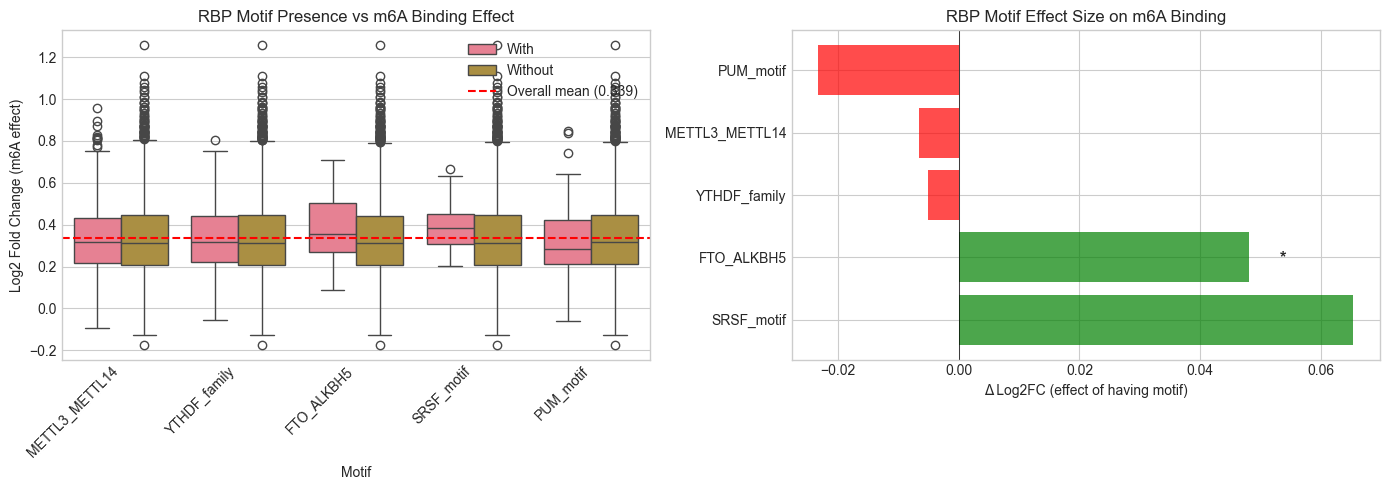


Key insight: Motifs associated with m6A writers/readers (METTL3_METTL14, YTHDF_family)
show effects on binding strength, indicating sequence context preferences.


In [8]:
# Visualize RBP motif effects on binding
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Box plots comparing with/without motif
ax = axes[0]
plot_data = []
for col in rbp_cols:
    motif_name = col.replace('has_', '')
    for has_it, label in [(True, 'With'), (False, 'Without')]:
        subset = df[df[col] == has_it]
        if len(subset) >= 10:
            for val in subset['log2_fold_change_median']:
                plot_data.append({'Motif': motif_name, 'Has Motif': label, 'log2FC': val})

plot_df = pd.DataFrame(plot_data)
# Filter to motifs with enough samples
motifs_to_plot = [m for m in plot_df['Motif'].unique() 
                  if len(plot_df[(plot_df['Motif'] == m) & (plot_df['Has Motif'] == 'With')]) >= 10]
plot_df = plot_df[plot_df['Motif'].isin(motifs_to_plot)]

if len(plot_df) > 0:
    sns.boxplot(data=plot_df, x='Motif', y='log2FC', hue='Has Motif', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.axhline(df['log2_fold_change_median'].mean(), color='red', linestyle='--', 
               label=f'Overall mean ({df["log2_fold_change_median"].mean():.3f})')
    ax.set_ylabel('Log2 Fold Change (m6A effect)')
    ax.set_title('RBP Motif Presence vs m6A Binding Effect')
    ax.legend(loc='upper right')

# Right: Effect size bar chart
ax = axes[1]
if len(motif_df) > 0:
    colors = ['green' if x > 0 else 'red' for x in motif_df['delta_effect']]
    bars = ax.barh(motif_df['motif'], motif_df['delta_effect'], color=colors, alpha=0.7)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Δ Log2FC (effect of having motif)')
    ax.set_title('RBP Motif Effect Size on m6A Binding')
    
    # Add significance markers
    for i, (_, row) in enumerate(motif_df.iterrows()):
        sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else ''
        if sig:
            x_pos = row['delta_effect'] + 0.005 if row['delta_effect'] > 0 else row['delta_effect'] - 0.015
            ax.text(x_pos, i, sig, va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR + 'rbp_motif_binding_effects.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey insight: Motifs associated with m6A writers/readers (METTL3_METTL14, YTHDF_family)")
print("show effects on binding strength, indicating sequence context preferences.")

In [9]:
# 5. Codon context (if this were in CDS)
# m6A in codons: AAA (Lys), GAC (Asp), etc.

CODON_TABLE = {
    'AAA': 'Lys', 'AAG': 'Lys',
    'GAC': 'Asp', 'GAU': 'Asp',
    'GAA': 'Glu', 'GAG': 'Glu',
    'AAC': 'Asn', 'AAU': 'Asn',
    'CAA': 'Gln', 'CAG': 'Gln',
    'UAA': 'Stop', 'UAG': 'Stop', 'UGA': 'Stop',
    'GAC': 'Asp',
}

def get_codon_context(loop):
    """Determine codon context if m6A were in a coding region."""
    # Center A at position 3 (0-indexed), codon could be positions 2,3,4 or 3,4,5 or 1,2,3
    # Position 3 = center A
    # Codon frames:
    # Frame 0: [1,2,3], [4,5,6] - A at pos3 is third position of codon [1,2,3]
    # Frame 1: [0,1,2], [3,4,5] - A at pos3 is first position of codon [3,4,5]
    # Frame 2: [2,3,4] - A at pos3 is second position of codon [2,3,4]
    
    results = {}
    
    # A at first codon position (most common for m6A)
    codon_1st = loop[3:6]  # A is first
    results['codon_A_1st'] = codon_1st
    results['aa_A_1st'] = CODON_TABLE.get(codon_1st, 'other')
    
    # A at third codon position (wobble)
    codon_3rd = loop[1:4]  # A is third
    results['codon_A_3rd'] = codon_3rd
    results['aa_A_3rd'] = CODON_TABLE.get(codon_3rd, 'other')
    
    return results

codon_context = df['loop_A'].apply(get_codon_context).apply(pd.Series)
df = pd.concat([df, codon_context], axis=1)

print("\nCodon context (A at 1st position):")
print(df['aa_A_1st'].value_counts().head(10))


Codon context (A at 1st position):
aa_A_1st
other    3072
Lys       512
Asn       512
Name: count, dtype: int64


In [10]:
# 6. Classify overall sequence context

def classify_context(row):
    """Create a comprehensive context classification."""
    tags = []
    
    # DRACH status
    if row['is_drach']:
        tags.append('DRACH')
    
    # Specific variant
    if 'GGACH' in row['drach_variant']:
        tags.append('canonical_GGACH')
    
    # Reader preferences
    if row['is_RRACH']:
        tags.append('YTHDF_preferred')
    if row['is_GRACU']:
        tags.append('YTHDC1_preferred')
    
    # Structural context
    if row['loop_au_content'] > 0.7:
        tags.append('AU_rich_loop')
    if row['loop_gc_content'] > 0.5:
        tags.append('GC_rich_loop')
        
    # Binding strength category
    fc = row['log2_fold_change_median']
    if fc > 0.5:
        tags.append('high_m6A_effect')
    elif fc < 0.2:
        tags.append('low_m6A_effect')
    else:
        tags.append('moderate_m6A_effect')
    
    return '|'.join(tags) if tags else 'unclassified'

df['context_tags'] = df.apply(classify_context, axis=1)

# Create a simplified category
df['binding_category'] = pd.cut(df['log2_fold_change_median'], 
                                 bins=[-np.inf, 0.2, 0.35, 0.5, np.inf],
                                 labels=['very_low', 'low', 'medium', 'high'])

print("\nBinding category distribution:")
print(df['binding_category'].value_counts())


Binding category distribution:
binding_category
low         1451
medium       979
very_low     929
high         737
Name: count, dtype: int64


## 3. Semantic Analysis: How Do Known Motifs Affect Binding?

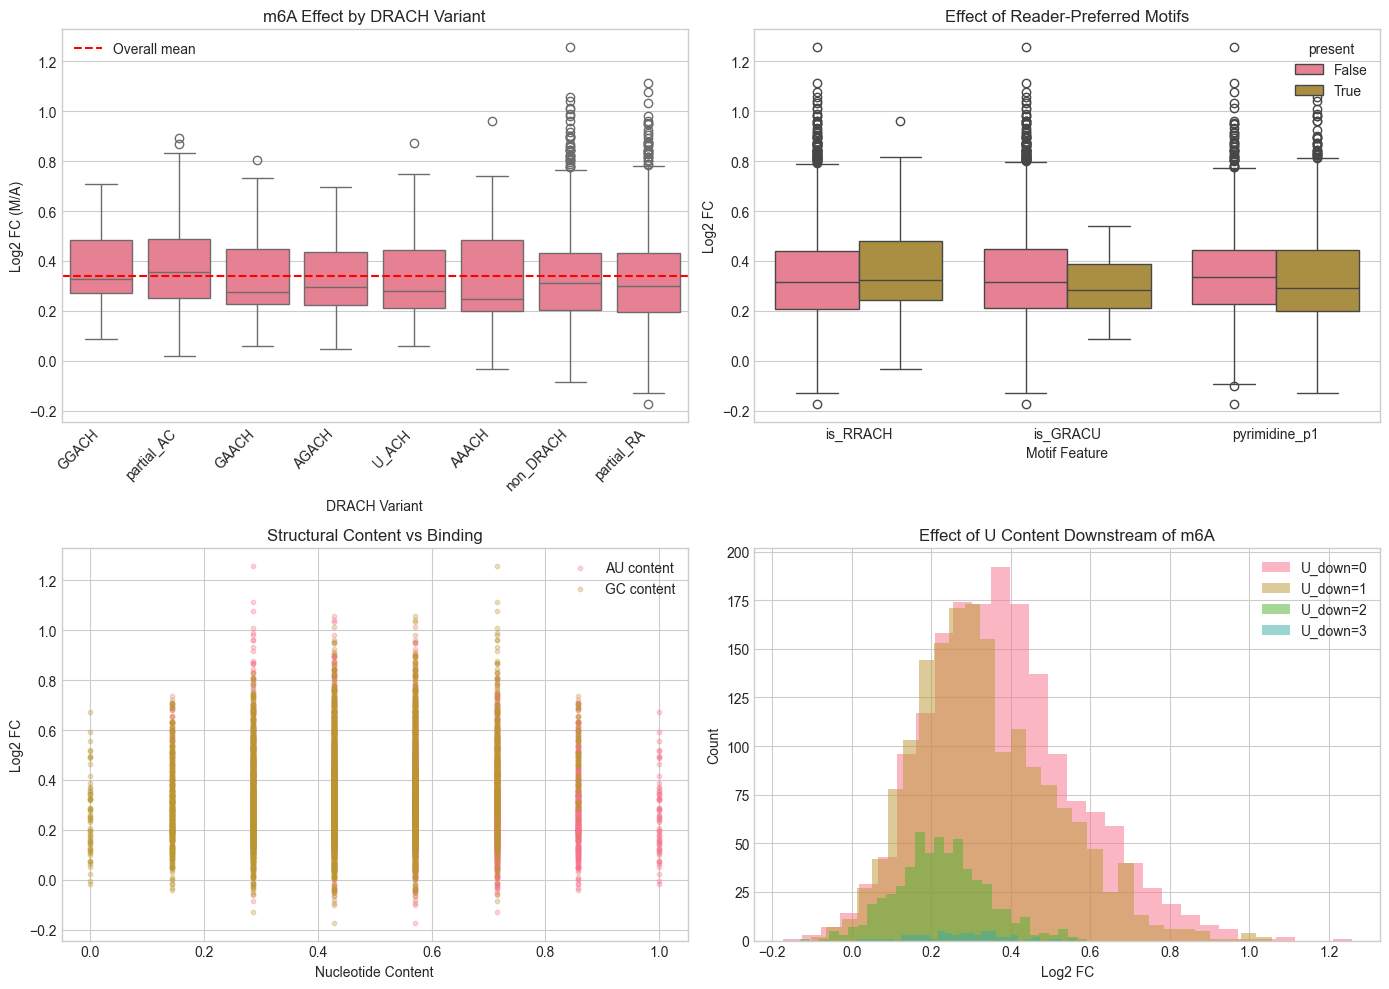

In [11]:
# Analyze binding by DRACH variant
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# DRACH variants
ax = axes[0, 0]
variant_order = df.groupby('drach_variant')['log2_fold_change_median'].mean().sort_values(ascending=False).index
sns.boxplot(data=df, x='drach_variant', y='log2_fold_change_median', order=variant_order, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axhline(df['log2_fold_change_median'].mean(), color='red', linestyle='--', label='Overall mean')
ax.set_xlabel('DRACH Variant')
ax.set_ylabel('Log2 FC (M/A)')
ax.set_title('m6A Effect by DRACH Variant')
ax.legend()

# By reader preference
ax = axes[0, 1]
reader_data = df.melt(id_vars=['log2_fold_change_median'], 
                      value_vars=['is_RRACH', 'is_GRACU', 'pyrimidine_p1'],
                      var_name='feature', value_name='present')
sns.boxplot(data=reader_data, x='feature', y='log2_fold_change_median', hue='present', ax=ax)
ax.set_xlabel('Motif Feature')
ax.set_ylabel('Log2 FC')
ax.set_title('Effect of Reader-Preferred Motifs')

# By structural features
ax = axes[1, 0]
ax.scatter(df['loop_au_content'], df['log2_fold_change_median'], alpha=0.3, s=10, label='AU content')
ax.scatter(df['loop_gc_content'], df['log2_fold_change_median'], alpha=0.3, s=10, label='GC content')
ax.set_xlabel('Nucleotide Content')
ax.set_ylabel('Log2 FC')
ax.set_title('Structural Content vs Binding')
ax.legend()

# Correlation with U downstream
ax = axes[1, 1]
for u_count in sorted(df['U_downstream'].unique()):
    subset = df[df['U_downstream'] == u_count]
    ax.hist(subset['log2_fold_change_median'], bins=30, alpha=0.5, label=f'U_down={u_count}')
ax.set_xlabel('Log2 FC')
ax.set_ylabel('Count')
ax.set_title('Effect of U Content Downstream of m6A')
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR + 'semantic_motif_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Statistical analysis of semantic features
print("="*70)
print("STATISTICAL ANALYSIS OF SEMANTIC FEATURES")
print("="*70)

# DRACH variants
print("\n1. DRACH VARIANT EFFECTS:")
for variant in df['drach_variant'].unique():
    subset = df[df['drach_variant'] == variant]
    print(f"   {variant:<15}: n={len(subset):>4}, log2FC={subset['log2_fold_change_median'].mean():.4f} ± {subset['log2_fold_change_median'].std():.4f}")

# ANOVA for variants
groups = [df[df['drach_variant'] == v]['log2_fold_change_median'].values 
          for v in df['drach_variant'].unique()]
f_stat, p_val = stats.f_oneway(*groups)
print(f"\n   ANOVA: F={f_stat:.2f}, p={p_val:.2e}")

# Correlation with continuous features
print("\n2. CORRELATION WITH SEMANTIC FEATURES:")
semantic_cols = ['U_downstream', 'A_upstream', 'G_content', 'purine_flanking',
                 'loop_au_content', 'loop_gc_content', 'self_complementarity',
                 'strong_stacks', 'weak_stacks', 'flexibility_proxy']

for col in semantic_cols:
    if col in df.columns:
        r, p = stats.spearmanr(df[col], df['log2_fold_change_median'])
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
        print(f"   {col:<25}: r={r:+.3f}, p={p:.2e} {sig}")

STATISTICAL ANALYSIS OF SEMANTIC FEATURES

1. DRACH VARIANT EFFECTS:
   partial_RA     : n=1536, log2FC=0.3257 ± 0.1875
   non_DRACH      : n=1536, log2FC=0.3324 ± 0.1783
   AAACH          : n=  48, log2FC=0.3328 ± 0.2173
   partial_AC     : n= 736, log2FC=0.3763 ± 0.1708
   GAACH          : n=  48, log2FC=0.3507 ± 0.1974
   U_ACH          : n=  96, log2FC=0.3342 ± 0.1789
   AGACH          : n=  48, log2FC=0.3381 ± 0.1703
   GGACH          : n=  48, log2FC=0.3764 ± 0.1628

   ANOVA: F=6.28, p=2.42e-07

2. CORRELATION WITH SEMANTIC FEATURES:
   U_downstream             : r=-0.257, p=1.33e-62 ***
   A_upstream               : r=+0.024, p=1.19e-01 
   G_content                : r=+0.064, p=3.90e-05 ***
   purine_flanking          : r=-0.028, p=6.83e-02 
   loop_au_content          : r=-0.208, p=2.28e-41 ***
   loop_gc_content          : r=+0.208, p=2.28e-41 ***
   self_complementarity     : r=+0.015, p=3.51e-01 
   strong_stacks            : r=+0.252, p=3.39e-60 ***
   weak_stacks        

## 4. Multi-Embedder Analysis

Compare embeddings from:
1. **NucleotideEmbedder**: Simple k-mer + stats features
2. **RNA-FM**: Pretrained RNA foundation model
3. **UTR-LM**: 5' UTR-specific language model

In [13]:
# Import embedders
from src.embedding.rna import NucleotideEmbedder

# Check availability of pretrained models
try:
    from src.embedding.rna import RNAFMEmbedder
    HAS_RNAFM = RNAFMEmbedder is not None
except:
    HAS_RNAFM = False

try:
    from src.embedding.rna import UTRLMEmbedder
    HAS_UTRLM = UTRLMEmbedder is not None
except:
    HAS_UTRLM = False

print(f"NucleotideEmbedder: Available")
print(f"RNAFMEmbedder: {'Available' if HAS_RNAFM else 'Not available'}")
print(f"UTRLMEmbedder: {'Available' if HAS_UTRLM else 'Not available'}")

NucleotideEmbedder: Available
RNAFMEmbedder: Available
UTRLMEmbedder: Available


In [14]:
# Prepare sequences
sequences_loop = df['loop_A'].tolist()  # 7-mer loops
sequences_full = df['sequence_A'].tolist()  # Full hairpin (37nt)

# Store all embeddings
embeddings_dict = {}

In [15]:
# 1. NucleotideEmbedder (loops and full sequences)
print("="*60)
print("1. NUCLEOTIDE EMBEDDER")
print("="*60)

# For loops (7-mer) - simpler features
nuc_embedder_loop = NucleotideEmbedder(
    include_onehot=True,
    include_kmers=True,
    kmer_sizes=[2, 3],
    include_stats=True,
    include_structure=False,
    include_positional=True,
    num_position_bins=7
)

print(f"Embedding loops (dim={nuc_embedder_loop.embedding_dim})...")
embeddings_dict['nucleotide_loop'] = nuc_embedder_loop.encode(sequences_loop)
print(f"  Shape: {embeddings_dict['nucleotide_loop'].shape}")

# For full sequences
nuc_embedder_full = NucleotideEmbedder(
    include_onehot=True,
    include_kmers=True,
    kmer_sizes=[3, 4],
    include_stats=True,
    include_structure=False,
    include_positional=True,
    num_position_bins=10
)

print(f"Embedding full sequences (dim={nuc_embedder_full.embedding_dim})...")
embeddings_dict['nucleotide_full'] = nuc_embedder_full.encode(sequences_full)
print(f"  Shape: {embeddings_dict['nucleotide_full'].shape}")

1. NUCLEOTIDE EMBEDDER
Embedding loops (dim=120)...
  Shape: (4096, 120)
Embedding full sequences (dim=372)...
  Shape: (4096, 372)


In [16]:
# 2. RNA-FM Embedder (if available)
if HAS_RNAFM:
    print("="*60)
    print("2. RNA-FM EMBEDDER")
    print("="*60)
    
    try:
        rnafm_embedder = RNAFMEmbedder(device='cpu', pooling='mean')
        
        print(f"Embedding full sequences with RNA-FM (dim={rnafm_embedder.embedding_dim})...")
        # RNA-FM needs sequences without M (methylation marker)
        seqs_clean = [s.replace('T', 'U') for s in sequences_full]
        embeddings_dict['rnafm_full'] = rnafm_embedder.batch_encode(seqs_clean, show_progress=True)
        print(f"  Shape: {embeddings_dict['rnafm_full'].shape}")
        
    except Exception as e:
        print(f"RNA-FM encoding failed: {e}")
        HAS_RNAFM = False
else:
    print("Skipping RNA-FM (not available)")

2. RNA-FM EMBEDDER
Loading RNA-FM model: rna_fm_t12
  RNA-FM loaded on cpu (frozen)
Embedding full sequences with RNA-FM (dim=640)...


Encoding with RNA-FM: 100%|██████████| 128/128 [00:40<00:00,  3.14it/s]

  Shape: (4096, 640)


In [17]:
# 3. UTR-LM Embedder (if available)
if HAS_UTRLM:
    print("="*60)
    print("3. UTR-LM EMBEDDER")
    print("="*60)
    
    try:
        utrlm_embedder = UTRLMEmbedder(
            model_path="multimolecule/utrlm-te_el",
            pooling='mean',
            trainable=False
        )
        
        print(f"Embedding full sequences with UTR-LM (dim={utrlm_embedder.embed_dim})...")
        seqs_clean = [s.replace('T', 'U') for s in sequences_full]
        
        # Batch encode
        embeddings_list = []
        batch_size = 64
        for i in range(0, len(seqs_clean), batch_size):
            batch = seqs_clean[i:i+batch_size]
            batch_emb = utrlm_embedder.encode(batch)
            embeddings_list.append(batch_emb)
            if (i // batch_size) % 10 == 0:
                print(f"  Processed {i+len(batch)}/{len(seqs_clean)}")
        
        embeddings_dict['utrlm_full'] = np.vstack(embeddings_list)
        print(f"  Shape: {embeddings_dict['utrlm_full'].shape}")
        
    except Exception as e:
        print(f"UTR-LM encoding failed: {e}")
        HAS_UTRLM = False
else:
    print("Skipping UTR-LM (not available)")

3. UTR-LM EMBEDDER
Loading UTR-LM from HuggingFace: multimolecule/utrlm-te_el


Some weights of UtrLmModel were not initialized from the model checkpoint at multimolecule/utrlm-te_el and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded UTR-LM with embed_dim=128
Embedding full sequences with UTR-LM (dim=128)...
  Processed 64/4096
  Processed 704/4096
  Processed 1344/4096
  Processed 1984/4096
  Processed 2624/4096
  Processed 3264/4096
  Processed 3904/4096
  Shape: (4096, 128)


In [18]:
# Summary of embeddings
print("\n" + "="*60)
print("EMBEDDING SUMMARY")
print("="*60)
for name, emb in embeddings_dict.items():
    print(f"{name:<20}: shape={emb.shape}, dtype={emb.dtype}")


EMBEDDING SUMMARY
nucleotide_loop     : shape=(4096, 120), dtype=float32
nucleotide_full     : shape=(4096, 372), dtype=float32
rnafm_full          : shape=(4096, 640), dtype=float32
utrlm_full          : shape=(4096, 128), dtype=float32


## 5. Dimensionality Reduction: PCA, t-SNE, UMAP

Compare all embedders side-by-side with multiple reduction methods.

In [19]:
def compute_dim_reductions(embeddings, name, n_pca=50, perplexity=30, n_neighbors=15):
    """
    Compute PCA, t-SNE, and UMAP for embeddings.
    Returns dict with reduced coordinates.
    """
    print(f"\nProcessing {name}...")
    results = {'name': name}
    
    # Standardize
    scaler = StandardScaler()
    X = scaler.fit_transform(embeddings)
    
    # PCA
    print(f"  Computing PCA...")
    pca = PCA(n_components=min(n_pca, X.shape[1]))
    X_pca = pca.fit_transform(X)
    results['pca'] = X_pca[:, :2]  # First 2 components for viz
    results['pca_var'] = pca.explained_variance_ratio_[:2].sum()
    results['pca_full'] = X_pca  # For t-SNE input
    print(f"    Variance explained (2 PCs): {results['pca_var']:.3f}")
    
    # t-SNE (on PCA-reduced data for efficiency)
    print(f"  Computing t-SNE...")
    n_pca_for_tsne = min(30, X_pca.shape[1])
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    results['tsne'] = tsne.fit_transform(X_pca[:, :n_pca_for_tsne])
    
    # UMAP (if available)
    if HAS_UMAP:
        print(f"  Computing UMAP...")
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors, min_dist=0.1)
        results['umap'] = reducer.fit_transform(X_pca[:, :n_pca_for_tsne])
    else:
        results['umap'] = None
    
    return results

# Compute reductions for all embeddings
reductions = {}
for name, emb in embeddings_dict.items():
    reductions[name] = compute_dim_reductions(emb, name)


Processing nucleotide_loop...
  Computing PCA...
    Variance explained (2 PCs): 0.151
  Computing t-SNE...
  Computing UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



Processing nucleotide_full...
  Computing PCA...
    Variance explained (2 PCs): 0.080
  Computing t-SNE...
  Computing UMAP...

Processing rnafm_full...
  Computing PCA...
    Variance explained (2 PCs): 0.418
  Computing t-SNE...
  Computing UMAP...

Processing utrlm_full...
  Computing PCA...
    Variance explained (2 PCs): 0.413
  Computing t-SNE...
  Computing UMAP...


In [20]:
def plot_embeddings_comparison(reductions_dict, color_by, color_label, cmap='RdYlBu_r', 
                               figsize=(18, 5), alpha=0.5, s=8):
    """
    Plot PCA, t-SNE, UMAP side by side for each embedder.
    """
    n_embedders = len(reductions_dict)
    n_methods = 3 if HAS_UMAP else 2
    
    fig, axes = plt.subplots(n_embedders, n_methods, figsize=(figsize[0], figsize[1] * n_embedders))
    if n_embedders == 1:
        axes = axes.reshape(1, -1)
    
    methods = ['pca', 'tsne', 'umap'] if HAS_UMAP else ['pca', 'tsne']
    method_names = ['PCA', 't-SNE', 'UMAP'] if HAS_UMAP else ['PCA', 't-SNE']
    
    for i, (emb_name, red) in enumerate(reductions_dict.items()):
        for j, (method, method_name) in enumerate(zip(methods, method_names)):
            ax = axes[i, j]
            
            coords = red[method]
            if coords is None:
                ax.text(0.5, 0.5, 'Not available', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{emb_name} - {method_name}')
                continue
            
            scatter = ax.scatter(coords[:, 0], coords[:, 1], c=color_by, cmap=cmap, 
                               alpha=alpha, s=s, rasterized=True)
            
            if i == 0:
                ax.set_title(f'{method_name}', fontsize=12, fontweight='bold')
            if j == 0:
                ax.set_ylabel(f'{emb_name}', fontsize=11, fontweight='bold')
            
            # Add variance explained for PCA
            if method == 'pca':
                ax.text(0.02, 0.98, f"Var: {red['pca_var']:.1%}", transform=ax.transAxes,
                       fontsize=9, va='top')
            
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(scatter, cax=cbar_ax, label=color_label)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    return fig

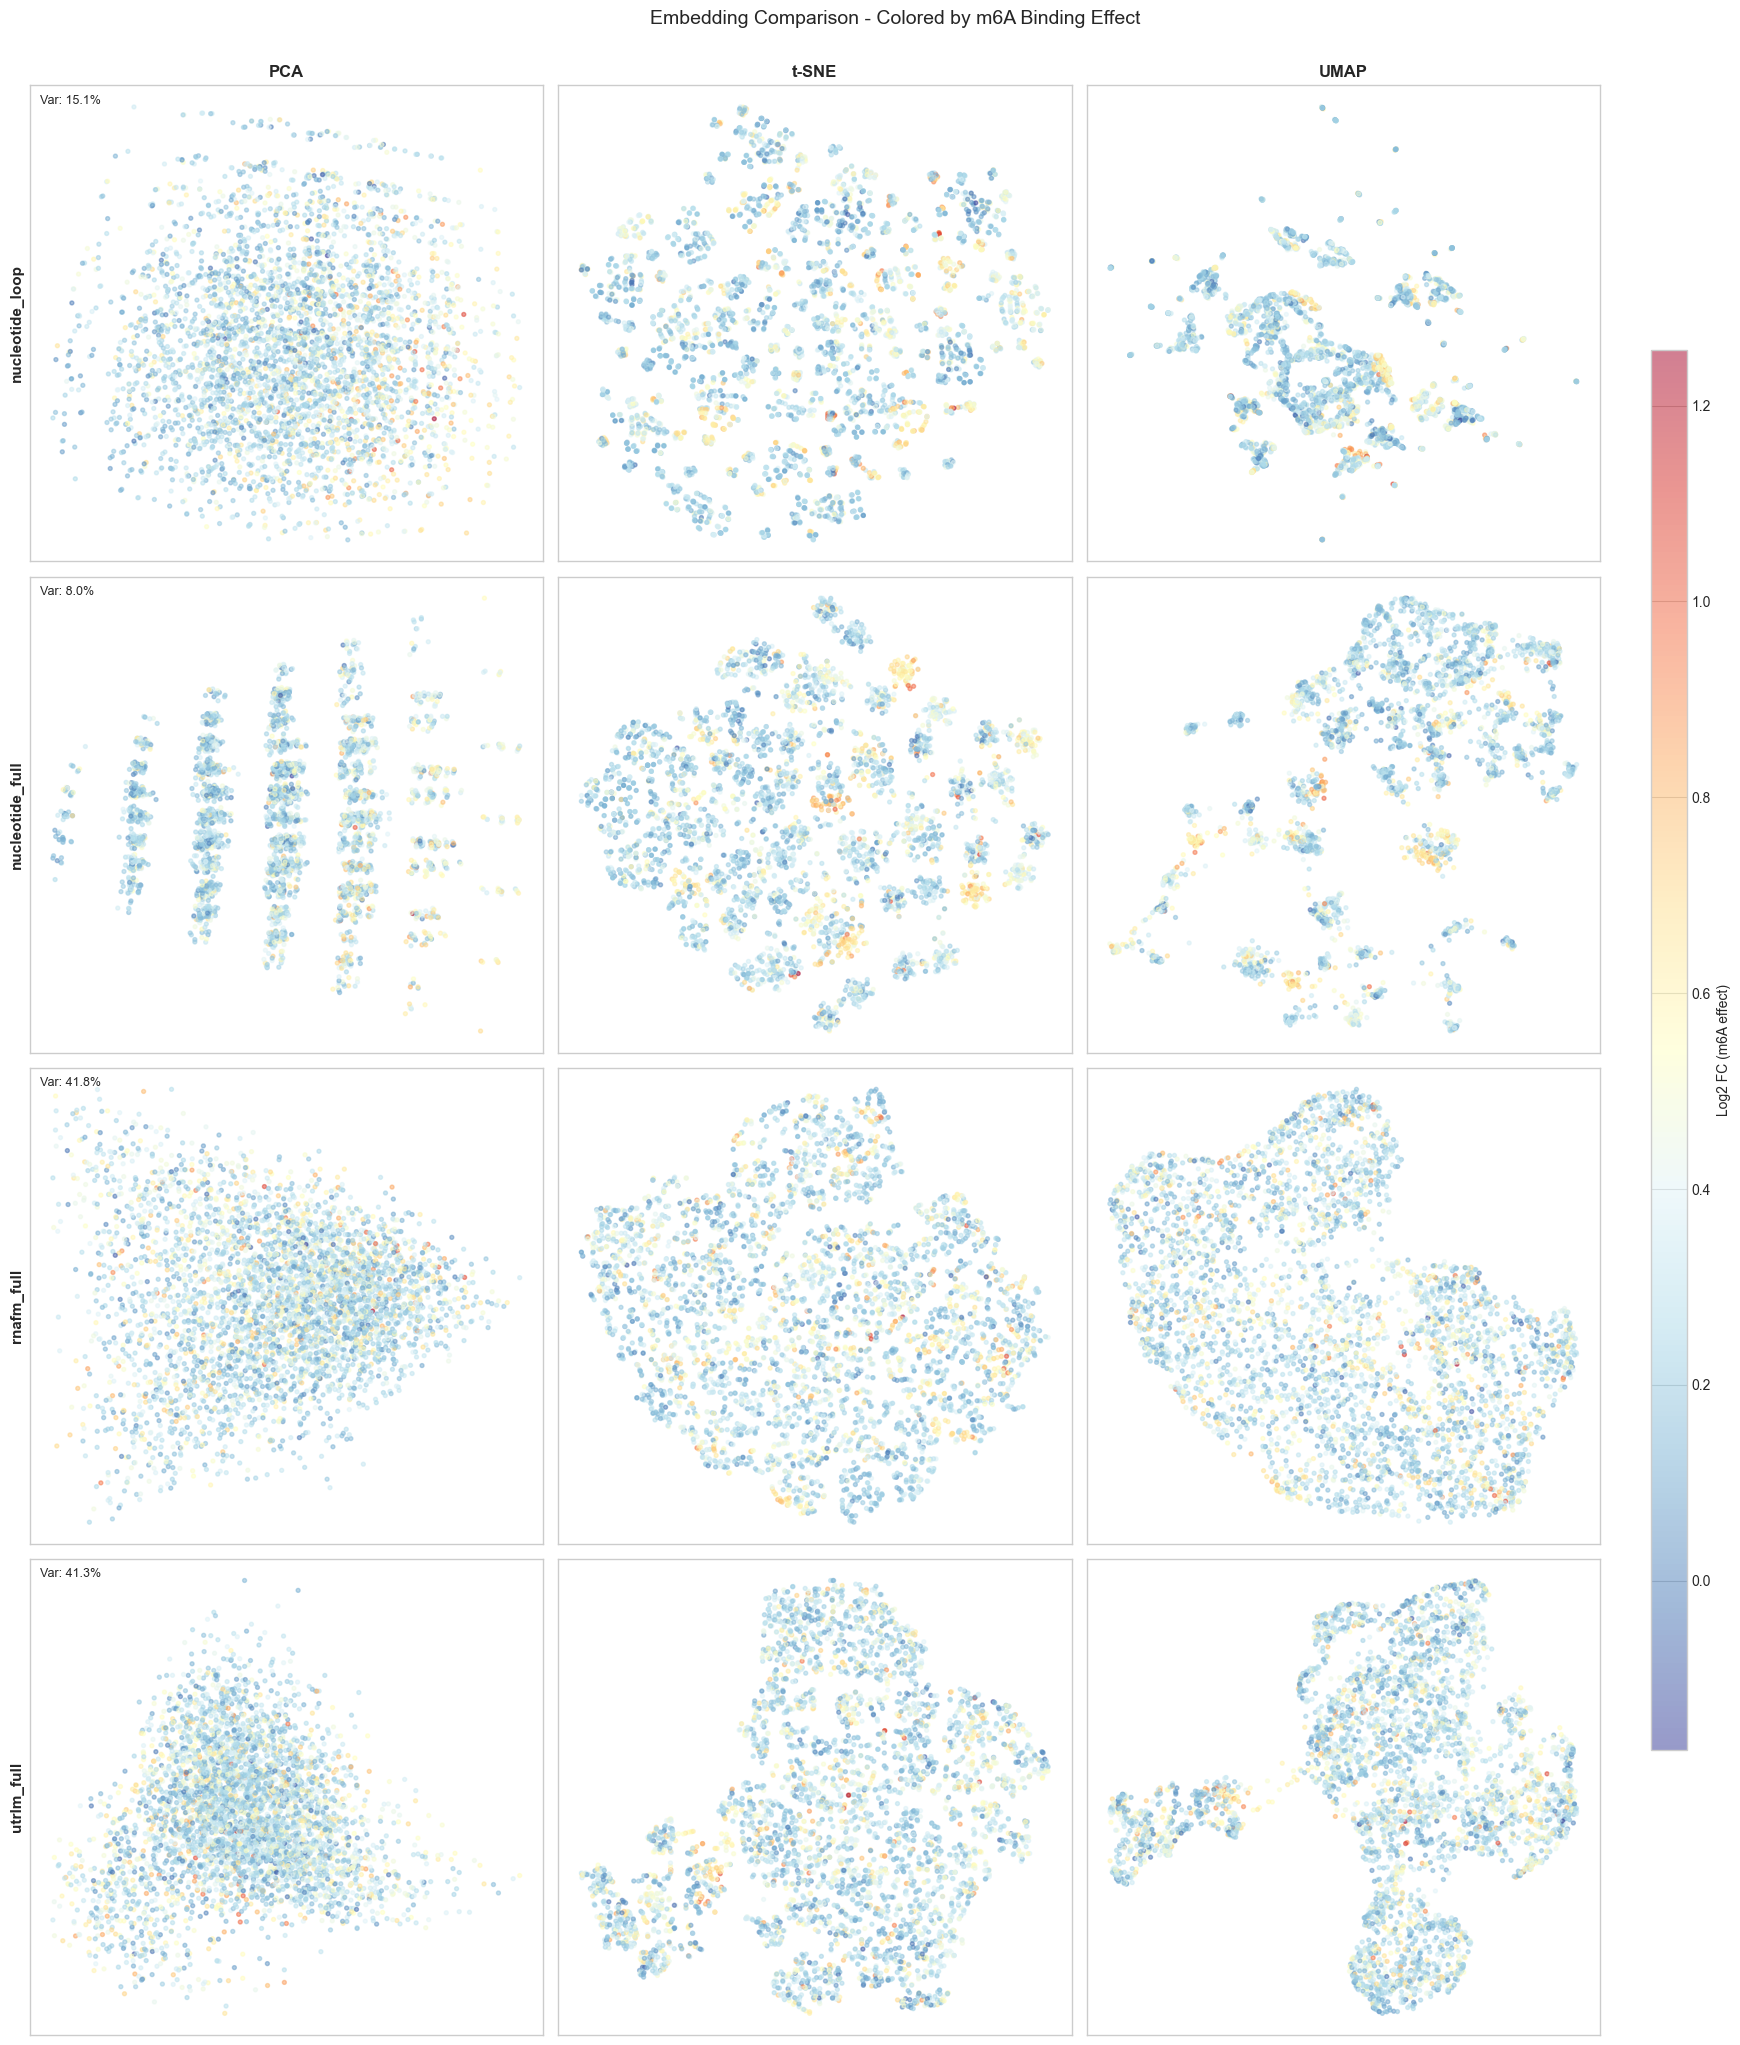

In [21]:
# Plot 1: Colored by log2 fold change
fig = plot_embeddings_comparison(
    reductions, 
    color_by=df['log2_fold_change_median'].values,
    color_label='Log2 FC (m6A effect)',
    cmap='RdYlBu_r'
)
fig.suptitle('Embedding Comparison - Colored by m6A Binding Effect', fontsize=14, y=1.02)
plt.savefig(FIG_DIR + 'embeddings_by_log2fc.png', dpi=150, bbox_inches='tight')
plt.show()

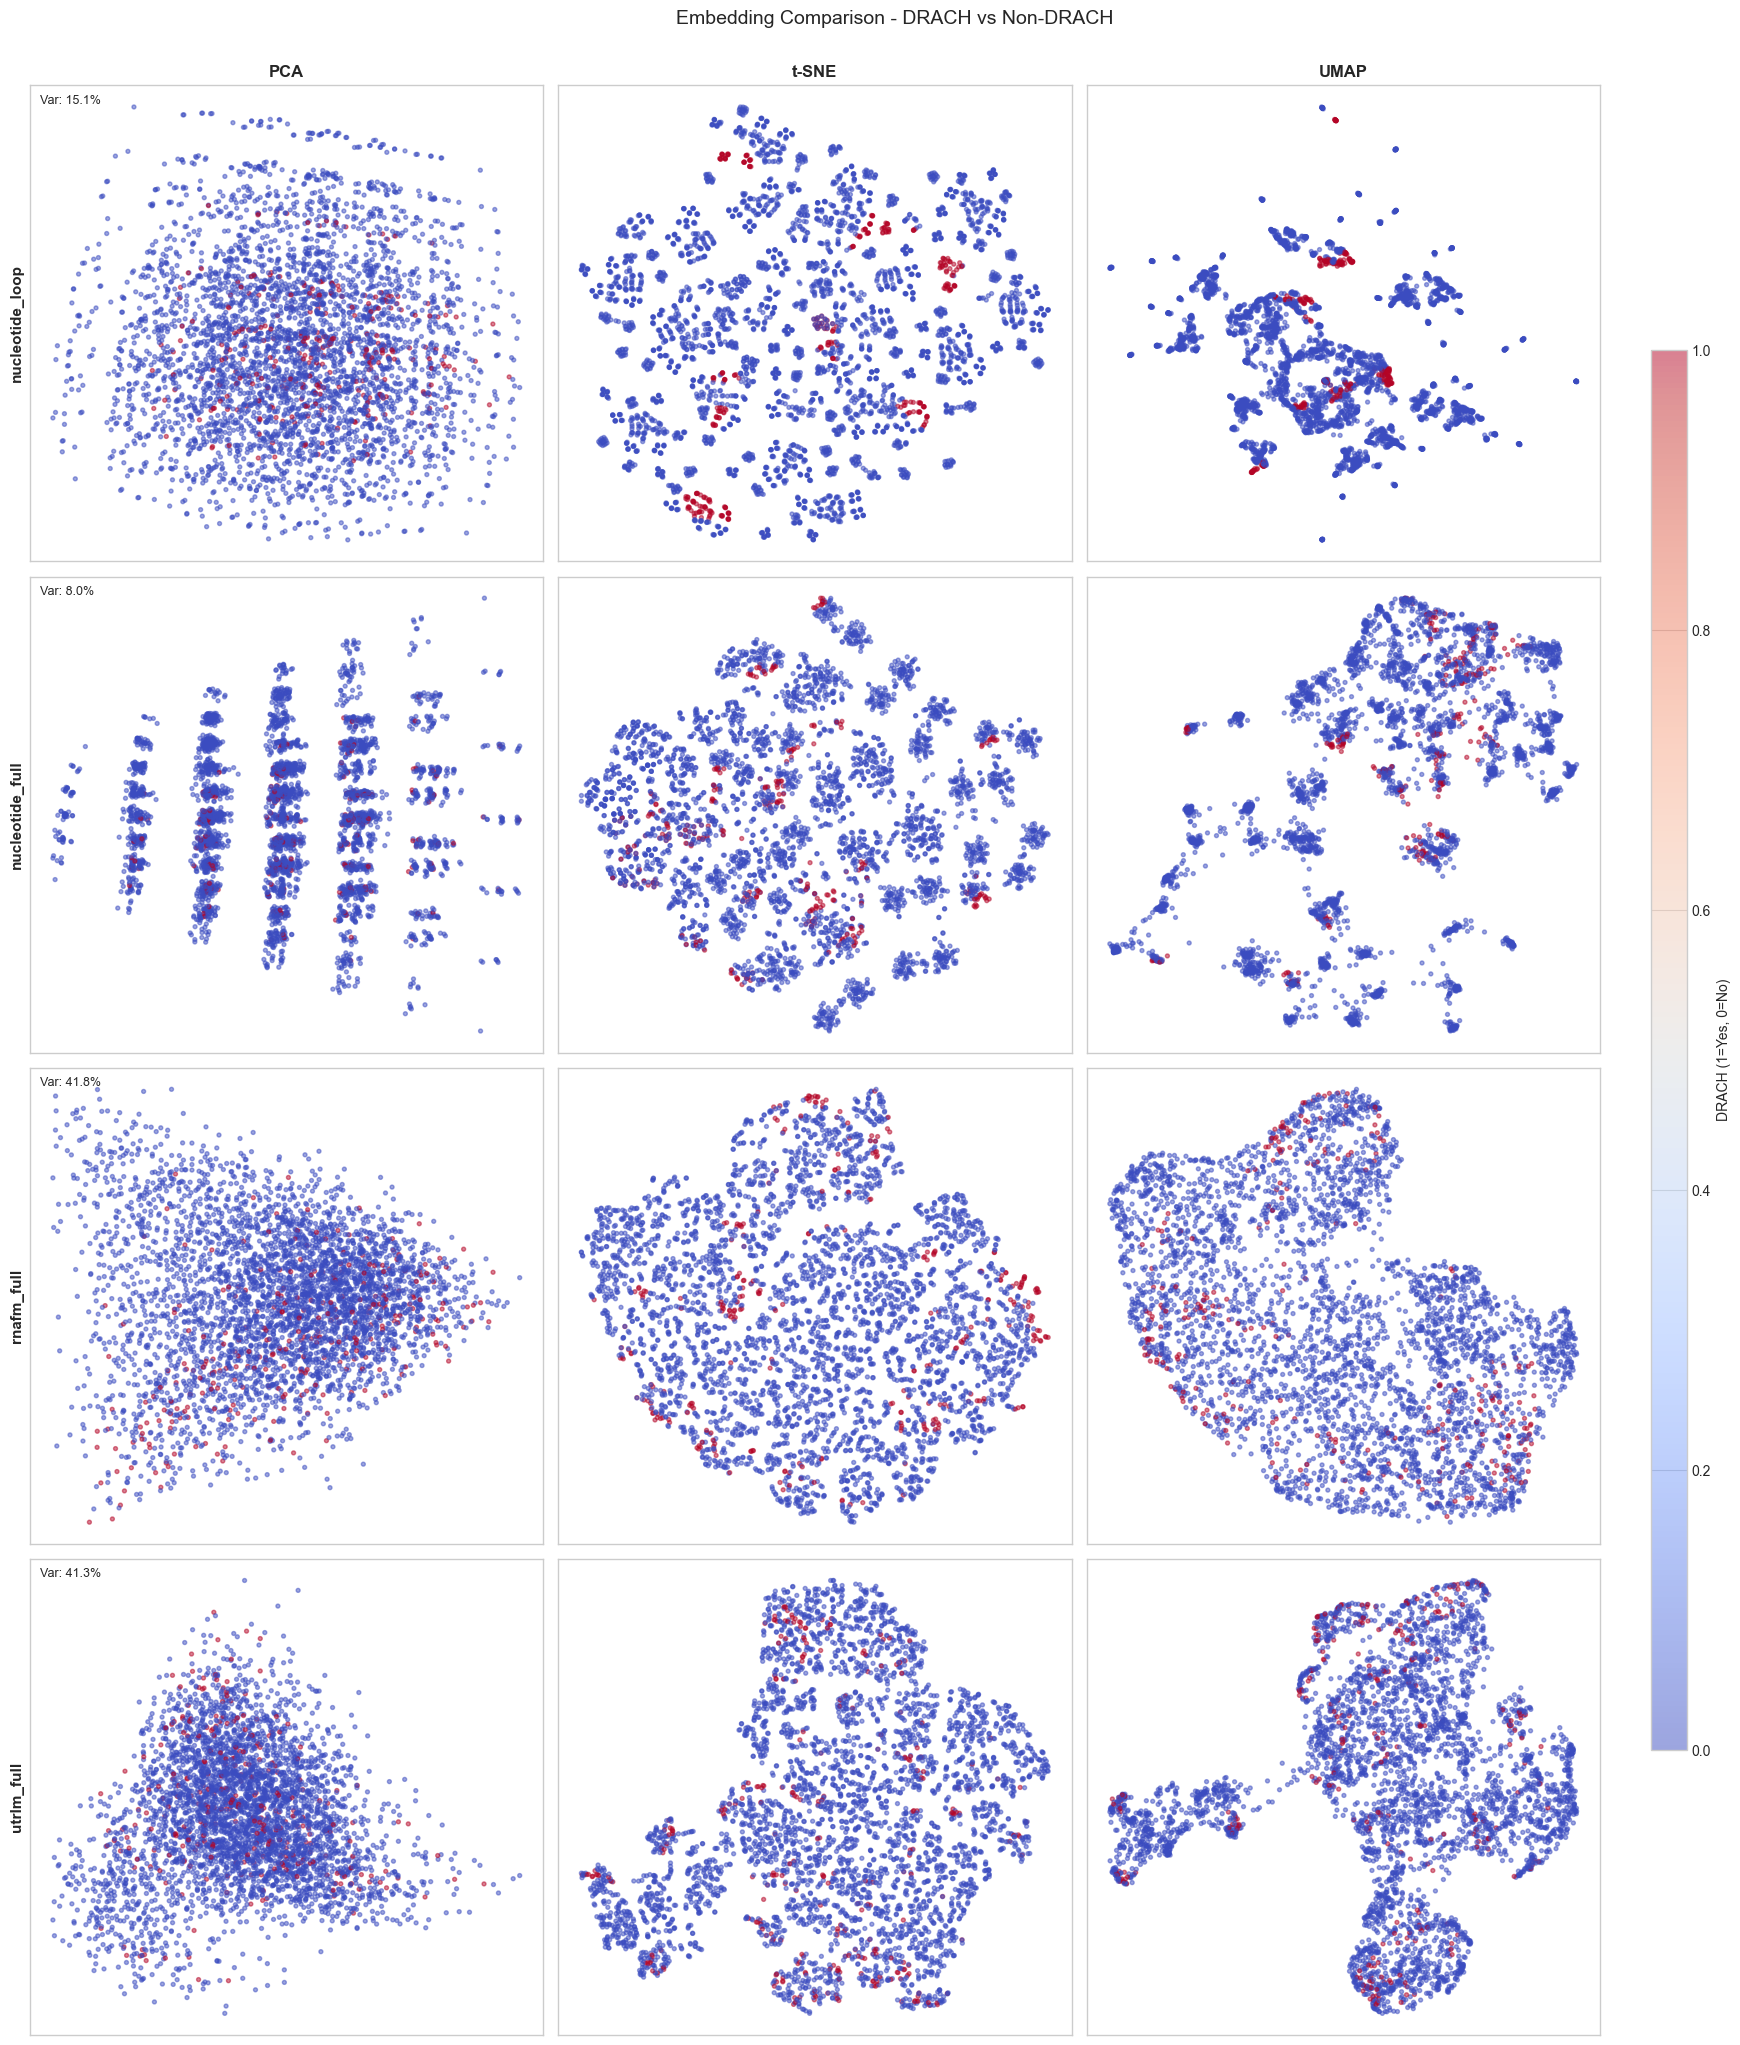

In [22]:
# Plot 2: Colored by DRACH status
fig = plot_embeddings_comparison(
    reductions,
    color_by=df['is_drach'].astype(int).values,
    color_label='DRACH (1=Yes, 0=No)',
    cmap='coolwarm'
)
fig.suptitle('Embedding Comparison - DRACH vs Non-DRACH', fontsize=14, y=1.02)
plt.savefig(FIG_DIR + 'embeddings_by_drach.png', dpi=150, bbox_inches='tight')
plt.show()

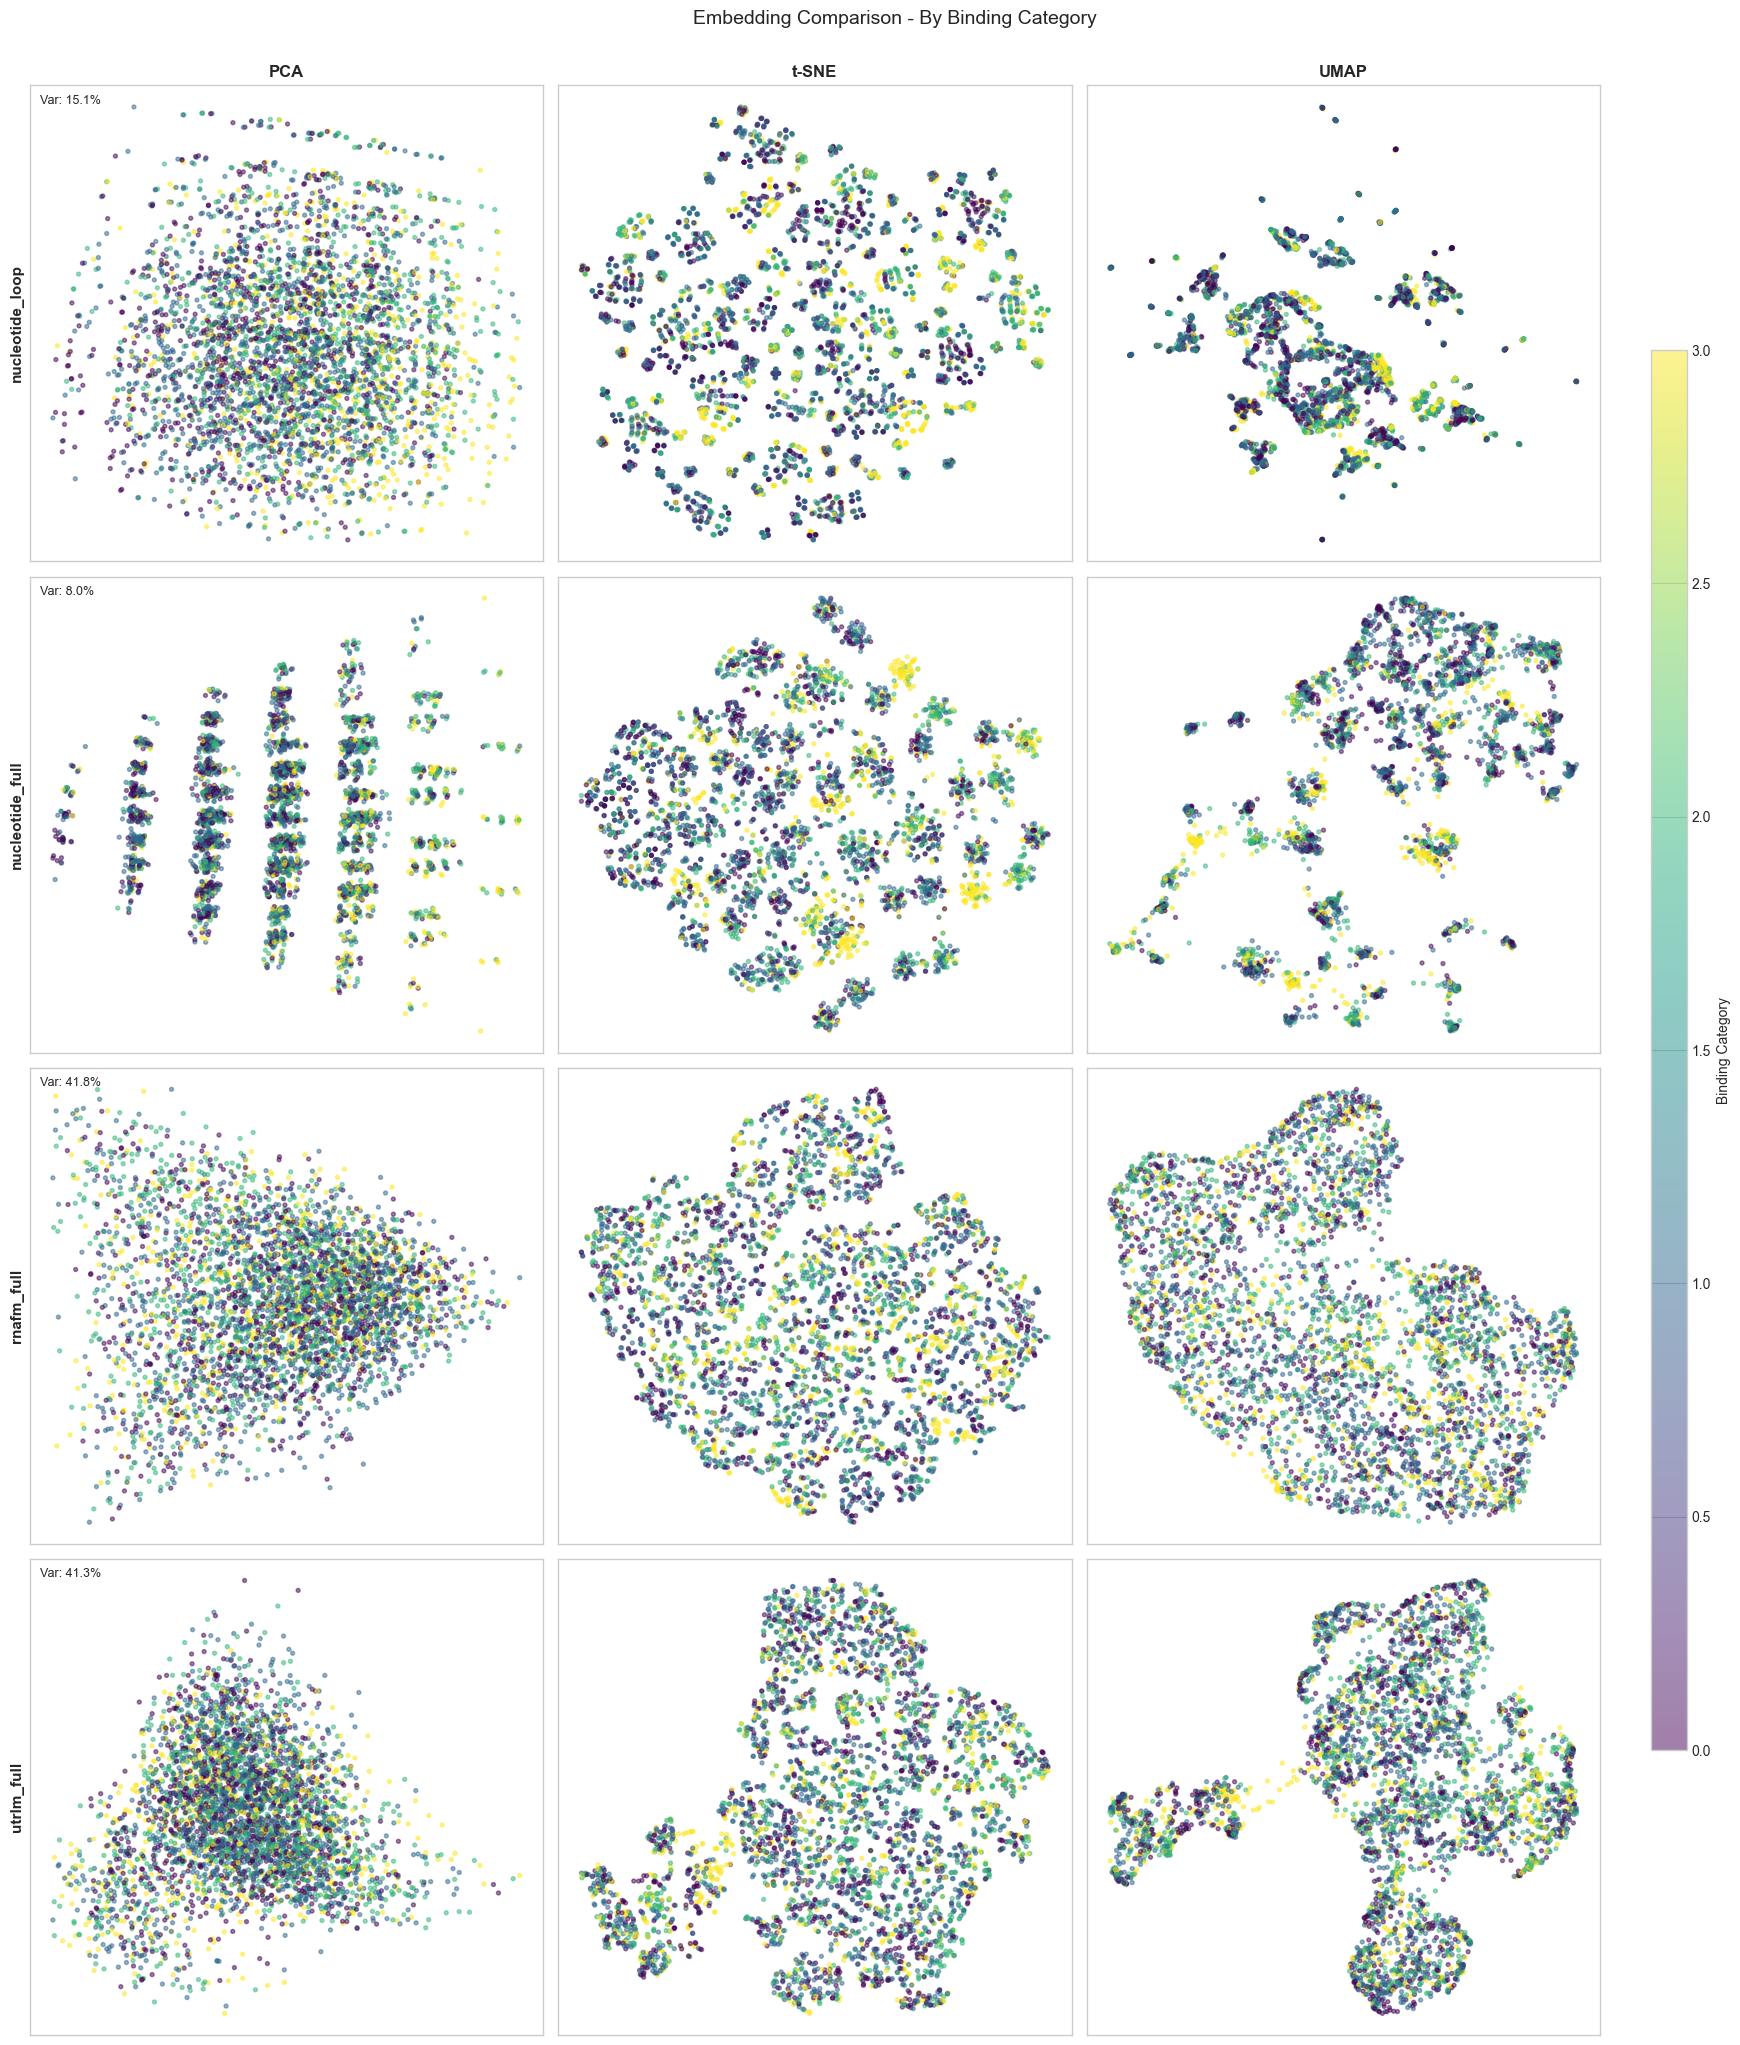

In [23]:
# Plot 3: Colored by binding category
category_map = {'very_low': 0, 'low': 1, 'medium': 2, 'high': 3}
color_values = df['binding_category'].map(category_map).values

fig = plot_embeddings_comparison(
    reductions,
    color_by=color_values,
    color_label='Binding Category',
    cmap='viridis'
)
fig.suptitle('Embedding Comparison - By Binding Category', fontsize=14, y=1.02)
plt.savefig(FIG_DIR + 'embeddings_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

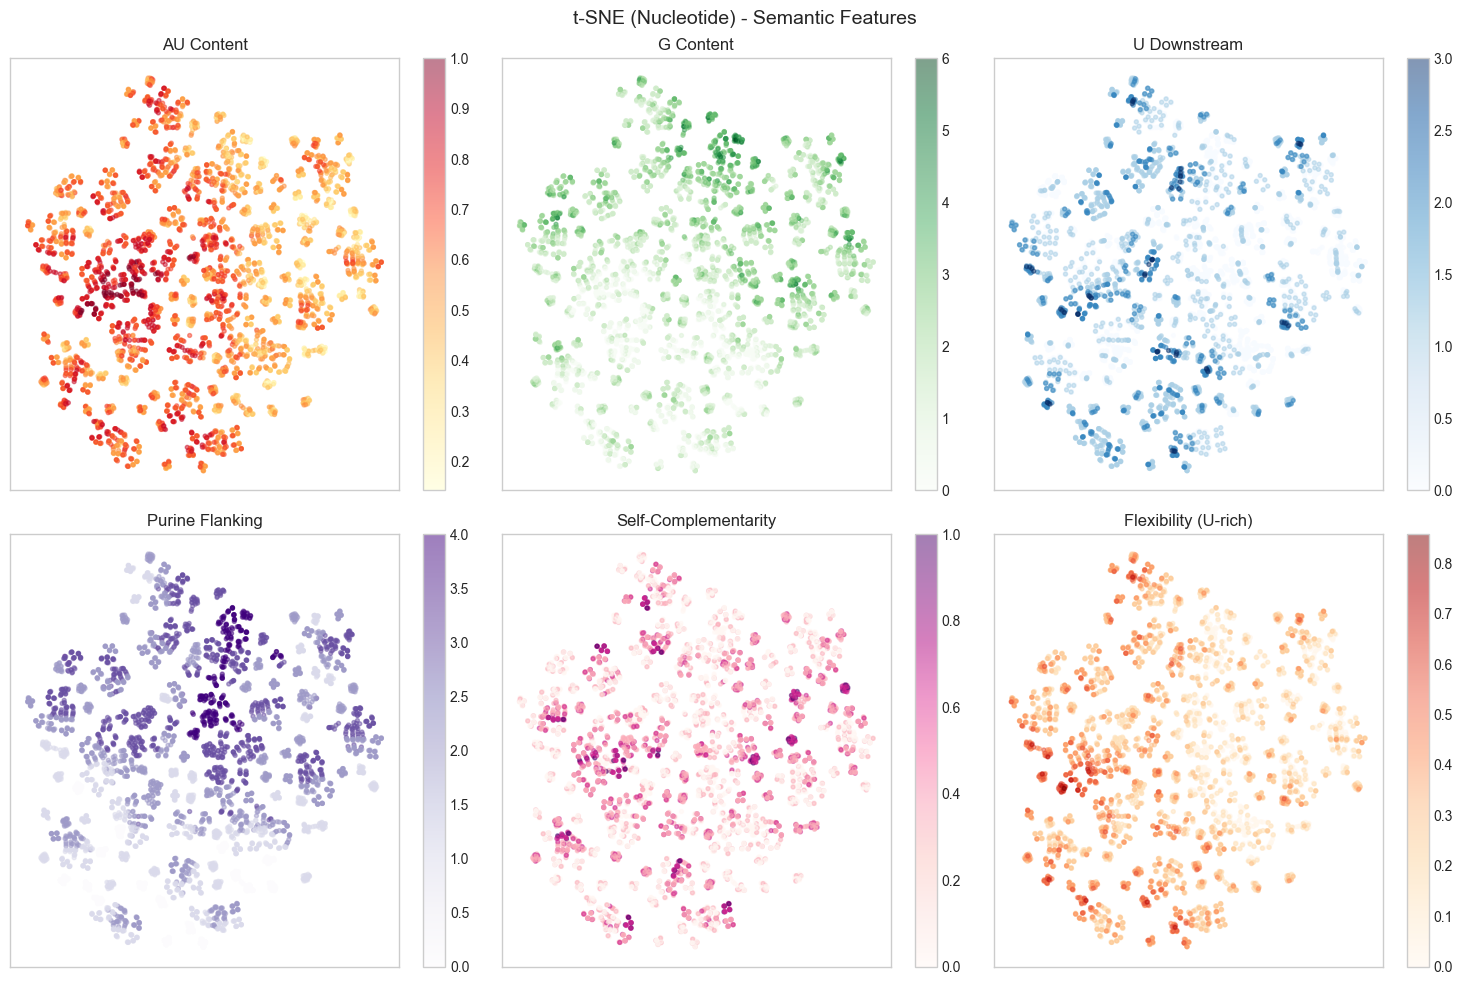

In [24]:
# Plot 4: Colored by semantic features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Use nucleotide_loop t-SNE for semantic coloring
coords = reductions['nucleotide_loop']['tsne']

semantic_features = [
    ('loop_au_content', 'AU Content', 'YlOrRd'),
    ('G_content', 'G Content', 'Greens'),
    ('U_downstream', 'U Downstream', 'Blues'),
    ('purine_flanking', 'Purine Flanking', 'Purples'),
    ('self_complementarity', 'Self-Complementarity', 'RdPu'),
    ('flexibility_proxy', 'Flexibility (U-rich)', 'OrRd')
]

for idx, (col, title, cmap) in enumerate(semantic_features):
    ax = axes[idx // 3, idx % 3]
    scatter = ax.scatter(coords[:, 0], coords[:, 1], c=df[col], cmap=cmap, alpha=0.5, s=8)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(scatter, ax=ax)

plt.suptitle('t-SNE (Nucleotide) - Semantic Features', fontsize=14)
plt.tight_layout()
plt.savefig(FIG_DIR + 'tsne_semantic_features.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Clustering Analysis with Semantic Interpretation

In [25]:
# Cluster using the best embedding
# Use nucleotide_full or rnafm_full if available

best_emb_name = 'rnafm_full' if 'rnafm_full' in embeddings_dict else 'nucleotide_full'
X_cluster = reductions[best_emb_name]['pca_full'][:, :20]  # Top 20 PCs

# K-means clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_cluster)

print(f"Clustered using {best_emb_name}")
print(f"Number of clusters: {n_clusters}")

Clustered using rnafm_full
Number of clusters: 10


In [26]:
# Analyze clusters with semantic features
cluster_analysis = df.groupby('cluster').agg({
    'log2_fold_change_median': ['mean', 'std', 'count'],
    'is_drach': 'mean',
    'is_RRACH': 'mean',
    'is_GRACU': 'mean',
    'loop_au_content': 'mean',
    'loop_gc_content': 'mean',
    'U_downstream': 'mean',
    'purine_flanking': 'mean',
    'self_complementarity': 'mean',
}).round(3)

cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns]
cluster_analysis = cluster_analysis.sort_values('log2_fold_change_median_mean', ascending=False)

print("\n" + "="*100)
print("CLUSTER ANALYSIS WITH SEMANTIC FEATURES")
print("="*100)
print(cluster_analysis.to_string())


CLUSTER ANALYSIS WITH SEMANTIC FEATURES
         log2_fold_change_median_mean  log2_fold_change_median_std  log2_fold_change_median_count  is_drach_mean  is_RRACH_mean  is_GRACU_mean  loop_au_content_mean  loop_gc_content_mean  U_downstream_mean  purine_flanking_mean  self_complementarity_mean
cluster                                                                                                                                                                                                                                                       
2                               0.373                        0.190                            555          0.018          0.029          0.005                 0.489                 0.511              0.757                 1.874                      0.203
6                               0.363                        0.198                            402          0.139          0.092          0.022                 0.441                 0.559        

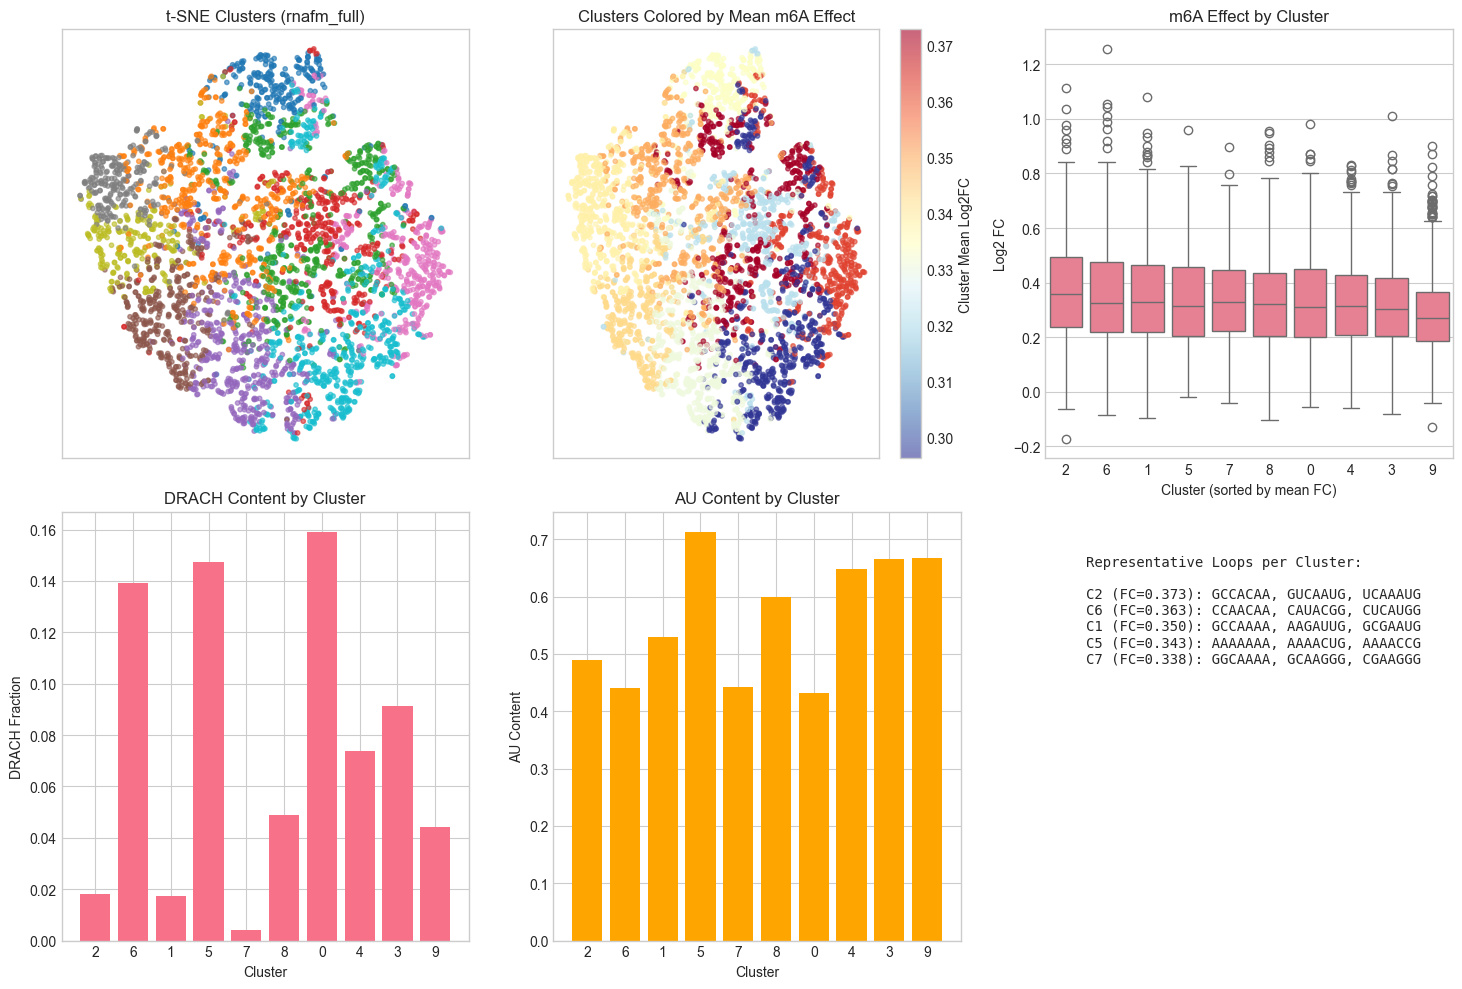

In [27]:
# Visualize clusters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

coords = reductions[best_emb_name]['tsne']

# Clusters
ax = axes[0, 0]
scatter = ax.scatter(coords[:, 0], coords[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6, s=10)
ax.set_title(f't-SNE Clusters ({best_emb_name})')
ax.set_xticks([]); ax.set_yticks([])

# Clusters colored by mean log2FC
ax = axes[0, 1]
cluster_means = df.groupby('cluster')['log2_fold_change_median'].mean()
cluster_colors = df['cluster'].map(cluster_means)
scatter = ax.scatter(coords[:, 0], coords[:, 1], c=cluster_colors, cmap='RdYlBu_r', alpha=0.6, s=10)
plt.colorbar(scatter, ax=ax, label='Cluster Mean Log2FC')
ax.set_title('Clusters Colored by Mean m6A Effect')
ax.set_xticks([]); ax.set_yticks([])

# Log2FC distribution per cluster
ax = axes[0, 2]
cluster_order = cluster_analysis.index.tolist()
sns.boxplot(data=df, x='cluster', y='log2_fold_change_median', order=cluster_order, ax=ax)
ax.set_xlabel('Cluster (sorted by mean FC)')
ax.set_ylabel('Log2 FC')
ax.set_title('m6A Effect by Cluster')

# DRACH fraction per cluster
ax = axes[1, 0]
drach_frac = df.groupby('cluster')['is_drach'].mean().reindex(cluster_order)
ax.bar(range(len(cluster_order)), drach_frac.values)
ax.set_xticks(range(len(cluster_order)))
ax.set_xticklabels(cluster_order)
ax.set_xlabel('Cluster')
ax.set_ylabel('DRACH Fraction')
ax.set_title('DRACH Content by Cluster')

# AU content per cluster
ax = axes[1, 1]
au_content = df.groupby('cluster')['loop_au_content'].mean().reindex(cluster_order)
ax.bar(range(len(cluster_order)), au_content.values, color='orange')
ax.set_xticks(range(len(cluster_order)))
ax.set_xticklabels(cluster_order)
ax.set_xlabel('Cluster')
ax.set_ylabel('AU Content')
ax.set_title('AU Content by Cluster')

# Representative sequences
ax = axes[1, 2]
ax.axis('off')
text = "Representative Loops per Cluster:\n\n"
for c in cluster_order[:5]:
    subset = df[df['cluster'] == c]
    top_loops = subset['loop_A'].value_counts().head(3).index.tolist()
    mean_fc = subset['log2_fold_change_median'].mean()
    text += f"C{c} (FC={mean_fc:.3f}): {', '.join(top_loops)}\n"
ax.text(0.1, 0.9, text, transform=ax.transAxes, fontsize=10, verticalalignment='top',
        fontfamily='monospace')

plt.tight_layout()
plt.savefig(FIG_DIR + 'cluster_semantic_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [28]:
# Detailed cluster characterization
print("\n" + "="*80)
print("DETAILED CLUSTER CHARACTERIZATION")
print("="*80)

for c in cluster_analysis.index[:5]:  # Top 5 clusters
    subset = df[df['cluster'] == c]
    print(f"\n--- Cluster {c} ---")
    print(f"Size: {len(subset)}")
    print(f"Mean Log2 FC: {subset['log2_fold_change_median'].mean():.4f}")
    print(f"DRACH: {100*subset['is_drach'].mean():.1f}%")
    print(f"AU content: {subset['loop_au_content'].mean():.3f}")
    print(f"GC content: {subset['loop_gc_content'].mean():.3f}")
    
    # Most common DRACH variants
    print(f"Top DRACH variants: {dict(subset['drach_variant'].value_counts().head(3))}")
    
    # Position preferences
    print(f"Position -1 (before A): {dict(subset['pos_m1'].value_counts())}")
    print(f"Position +1 (after A): {dict(subset['pos_p1'].value_counts())}")
    
    # Sample loops
    print(f"Sample loops: {subset['loop_A'].head(5).tolist()}")


DETAILED CLUSTER CHARACTERIZATION

--- Cluster 2 ---
Size: 555
Mean Log2 FC: 0.3729
DRACH: 1.8%
AU content: 0.489
GC content: 0.511
Top DRACH variants: {'non_DRACH': np.int64(249), 'partial_RA': np.int64(185), 'partial_AC': np.int64(111)}
Position -1 (before A): {'C': np.int64(242), 'G': np.int64(162), 'U': np.int64(86), 'A': np.int64(65)}
Position +1 (after A): {'G': np.int64(162), 'U': np.int64(151), 'C': np.int64(121), 'A': np.int64(121)}
Sample loops: ['GCCACAA', 'CGCACAA', 'UGCACAA', 'GUCACAA', 'ACGACAA']

--- Cluster 6 ---
Size: 402
Mean Log2 FC: 0.3628
DRACH: 13.9%
AU content: 0.441
GC content: 0.559
Top DRACH variants: {'partial_AC': np.int64(179), 'non_DRACH': np.int64(88), 'partial_RA': np.int64(79)}
Position -1 (before A): {'G': np.int64(164), 'C': np.int64(115), 'U': np.int64(71), 'A': np.int64(52)}
Position +1 (after A): {'C': np.int64(235), 'U': np.int64(109), 'A': np.int64(34), 'G': np.int64(24)}
Sample loops: ['CCAACAA', 'CCCACAA', 'CUCACAA', 'CCGACAA', 'UCGACAA']

---

## 7. Summary and Key Insights

In [29]:
print("\n" + "="*80)
print("SUMMARY OF KEY FINDINGS")
print("="*80)

print("\n1. OVERALL m6A EFFECT:")
print(f"   - m6A consistently increases YTH binding (mean log2FC = {df['log2_fold_change_median'].mean():.3f})")
print(f"   - {100*(df['log2_fold_change_median'] > 0).mean():.1f}% of sequences show M > A binding")

print("\n2. DRACH MOTIF ANALYSIS:")
drach = df[df['is_drach']]
non_drach = df[~df['is_drach']]
print(f"   - DRACH (n={len(drach)}): log2FC = {drach['log2_fold_change_median'].mean():.4f}")
print(f"   - Non-DRACH (n={len(non_drach)}): log2FC = {non_drach['log2_fold_change_median'].mean():.4f}")
print(f"   - Best variant: {df.groupby('drach_variant')['log2_fold_change_median'].mean().idxmax()}")

print("\n3. SEMANTIC FEATURES AFFECTING BINDING:")
semantic_cols = ['U_downstream', 'A_upstream', 'G_content', 'purine_flanking',
                 'loop_au_content', 'loop_gc_content', 'self_complementarity']
correlations = [(col, stats.spearmanr(df[col], df['log2_fold_change_median'])[0]) 
                for col in semantic_cols if col in df.columns]
correlations.sort(key=lambda x: abs(x[1]), reverse=True)
print("   Top correlations with m6A effect:")
for col, r in correlations[:5]:
    direction = "increases" if r > 0 else "decreases"
    print(f"   - {col}: r={r:+.3f} ({direction} binding)")

print("\n4. POSITION EFFECTS:")
positions = ['pos_m3', 'pos_m2', 'pos_m1', 'pos_p1', 'pos_p2', 'pos_p3']
for pos in positions:
    effects = {nuc: df[df[pos] == nuc]['log2_fold_change_median'].mean() for nuc in ['A', 'C', 'G', 'U']}
    best = max(effects, key=effects.get)
    worst = min(effects, key=effects.get)
    pos_name = pos.replace('pos_', '').replace('m', '-').replace('p', '+')
    print(f"   Position {pos_name:>3}: Best={best}({effects[best]:.3f}), Worst={worst}({effects[worst]:.3f})")

print("\n5. EMBEDDING ANALYSIS:")
for name, red in reductions.items():
    print(f"   {name}: PCA variance (2 PCs) = {red['pca_var']:.1%}")

print("\n6. CLUSTER INSIGHTS:")
high_cluster = cluster_analysis.index[0]
low_cluster = cluster_analysis.index[-1]
print(f"   - Highest binding cluster ({high_cluster}): log2FC={cluster_analysis.loc[high_cluster, 'log2_fold_change_median_mean']:.3f}")
print(f"   - Lowest binding cluster ({low_cluster}): log2FC={cluster_analysis.loc[low_cluster, 'log2_fold_change_median_mean']:.3f}")


SUMMARY OF KEY FINDINGS

1. OVERALL m6A EFFECT:
   - m6A consistently increases YTH binding (mean log2FC = 0.339)
   - 99.0% of sequences show M > A binding

2. DRACH MOTIF ANALYSIS:
   - DRACH (n=288): log2FC = 0.3444
   - Non-DRACH (n=3808): log2FC = 0.3382
   - Best variant: GGACH

3. SEMANTIC FEATURES AFFECTING BINDING:
   Top correlations with m6A effect:
   - U_downstream: r=-0.257 (decreases binding)
   - loop_au_content: r=-0.208 (decreases binding)
   - loop_gc_content: r=+0.208 (increases binding)
   - G_content: r=+0.064 (increases binding)
   - purine_flanking: r=-0.028 (decreases binding)

4. POSITION EFFECTS:
   Position  -3: Best=C(0.345), Worst=G(0.327)
   Position  -2: Best=C(0.354), Worst=G(0.323)
   Position  -1: Best=C(0.343), Worst=G(0.332)
   Position  +1: Best=C(0.367), Worst=U(0.300)
   Position  +2: Best=G(0.413), Worst=A(0.237)
   Position  +3: Best=A(0.397), Worst=U(0.284)

5. EMBEDDING ANALYSIS:
   nucleotide_loop: PCA variance (2 PCs) = 15.1%
   nucleotide

In [30]:
# Save enriched dataset
df.to_csv(DATA_DIR + 'm6a_analysis_enriched.csv', index=False)
print(f"\nSaved enriched dataset to: {DATA_DIR}m6a_analysis_enriched.csv")
print(f"Columns: {df.columns.tolist()}")


Saved enriched dataset to: /Users/shaharharel/Documents/github/edit-chem/data/rna/m6a/processed/m6a_analysis_enriched.csv
Columns: ['pair_id', 'name_A', 'name_M', 'sequence_A', 'sequence_M', 'loop_A', 'loop_M', 'type', 'type_custom', 'stem_len_each', 'total_len', 'intensity_median_A', 'intensity_mean_A', 'intensity_std_A', 'n_replicates_A', 'intensity_median_M', 'intensity_mean_M', 'intensity_std_M', 'n_replicates_M', 'delta_intensity_median', 'delta_intensity_mean', 'fold_change_median', 'fold_change_mean', 'log2_fold_change_median', 'log2_fold_change_mean', 'context_3nt_upstream', 'context_3nt_downstream', 'is_drach', 'pos_m3', 'pos_m2', 'pos_m1', 'center', 'pos_p1', 'pos_p2', 'pos_p3', 'drach_variant', 'is_RRACH', 'is_GRACU', 'U_downstream', 'A_upstream', 'G_content', 'purine_flanking', 'pyrimidine_p1', 'loop_au_content', 'loop_gc_content', 'self_complementarity', 'strong_stacks', 'weak_stacks', 'flexibility_proxy', 'has_METTL3_METTL14', 'has_YTHDF_family', 'has_YTHDC1', 'has_FTO_A